In [686]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [30]:
class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__()
        
        # Input layer
        self.fc1 = nn.Linear(len(predictors), 128)  # Adjust input size according to your dataset
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization for the first layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout for regularization
        
        # Hidden layer 1
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.4)
        
        # Hidden layer 2
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        # Hidden layer 3
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.3)
        
        # Output layer
        self.fc5 = nn.Linear(64, 1)
    
    def forward(self, x):
        # Forward pass through the network
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = self.fc5(x)  # Output layer (no activation function for regression)
        return x

In [172]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(len(predictors), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
        # Dropout layers for regularization
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))  # Leaky ReLU instead of ReLU for non-linearity
        x = self.dropout1(x)  # Apply dropout after the first layer
        x = F.leaky_relu(self.fc2(x))  # Leaky ReLU activation
        x = self.dropout2(x)  # Apply dropout after the second layer
        x = F.leaky_relu(self.fc3(x))  # Leaky ReLU activation
        x = self.dropout3(x)  # Apply dropout after the third layer
        x = self.fc4(x)  # Output layer (no activation for regression)
        return x

In [239]:
class FCNNModel(nn.Module):
    def __init__(self):
        super(FCNNModel, self).__init__()
        self.fc1 = nn.Linear(in_features=len(predictors), out_features=128)  # Assuming 7 Landsat bands as input features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [245]:
class CNN1DModel(nn.Module):
    def __init__(self):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * len(predictors), 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Adding channel dimension
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [669]:
# Load the dataset
csv_file = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive/python_modules/test/L30_obs_2013.csv'
data = pd.read_csv(csv_file)
data['chl_a_i'] = (data['green'] - data['red']) / (data['blue'] - data['red'])
# (0) target var
target = 'itemCloa'

# (1) delete outliers
Q1 = data['itemCloa'].quantile(0.25)
Q3 = data['itemCloa'].quantile(0.75)
IQR = Q3 - Q1
# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['itemCloa'] >= lower_bound) & (data['itemCloa'] <= upper_bound)]

# (2) conditions
#data = data.drop_duplicates(subset=['ptNo', 'hls_date'], keep='first')
data = data[data['delta_days'] <= 15] #best 15
data = data[data['mndwi'] > 0.8] #best 0.8
data = data[data['ndci'] < 1] #best 1

# (3) Define predictors (X) and target (y)
predictors = [#'delta_days',
    'blue', 'green', 'red', 'nir', 'swir1', 'swir2','chl_a_i',#'tir1','tir2',
    'blue_var', 'green_var', 'red_var', 'nir_var',
    'swir1_var', 'swir2_var'
    #,'mndwi', 'ndci'
]
X = data[predictors]
y = data[target]

# Combine X and y for easier row-wise operation
combined = pd.concat([X, y], axis=1)

# Remove rows with any NaN values
combined_cleaned = combined.dropna()

# Remove rows with any infinite values
combined_cleaned = combined_cleaned[~combined_cleaned.isin([np.inf, -np.inf]).any(axis=1)]

# Remove 'delta_days' from X
y_cleaned = combined_cleaned[target]
X_cleaned = combined_cleaned.drop(columns=[target])

# Split the cleaned data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Standardize the feature data
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Scale the target data (y)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)) #y_train.values.reshape(-1, 1) #
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)) #y_test.values.reshape(-1, 1) 

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) #128
print(X_cleaned.shape)

(402, 13)


/var/folders/fw/yjww5vk95hz1r22qhsb9btp40000gn/T/ipykernel_96781/2945119268.py:3: DtypeWarning: Columns (50,51,52,56,58,62,63,66,70,73,74,75,76,77,79,81) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_file)


In [692]:
# Initialize the model
#model = SimpleNN()
#model = ComplexNN()
model = FCNNModel() #best
#model = CNN1DModel()

# Define the loss function and optimizer
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5) #best
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8, nesterov=True)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Training loop
epochs = 500  # best 500
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        
        # Calculate RMSE as the loss
        mse_loss = F.mse_loss(outputs, batch_y)  # Calculate MSE
        rmse_loss = torch.sqrt(mse_loss)         # Convert MSE to RMSE
        
        rmse_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, RMSE: {rmse_loss.item():.4f}")
    
    # Adjust learning rate if the validation loss plateaus
    scheduler.step(rmse_loss)

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f"Mean Squared Error on test data: {test_loss.item():.4f}")

# Make predictions (optional)
predictions = model(X_test_tensor)

Epoch 1/500, RMSE: 0.8613
Epoch 2/500, RMSE: 1.1646
Epoch 3/500, RMSE: 0.9086
Epoch 4/500, RMSE: 0.7733
Epoch 5/500, RMSE: 1.0703
Epoch 6/500, RMSE: 1.0792
Epoch 7/500, RMSE: 0.9250
Epoch 8/500, RMSE: 0.9555
Epoch 9/500, RMSE: 0.8418
Epoch 10/500, RMSE: 0.8187
Epoch 11/500, RMSE: 0.9742
Epoch 12/500, RMSE: 0.7411
Epoch 13/500, RMSE: 0.7985
Epoch 14/500, RMSE: 0.8302
Epoch 15/500, RMSE: 0.9015
Epoch 16/500, RMSE: 0.8997
Epoch 17/500, RMSE: 0.7089
Epoch 18/500, RMSE: 0.8947
Epoch 19/500, RMSE: 0.7179
Epoch 20/500, RMSE: 0.7631
Epoch 21/500, RMSE: 0.7422
Epoch 22/500, RMSE: 0.6666
Epoch 23/500, RMSE: 0.8135
Epoch 24/500, RMSE: 0.7184
Epoch 25/500, RMSE: 0.9638
Epoch 26/500, RMSE: 0.7355
Epoch 27/500, RMSE: 0.6631
Epoch 28/500, RMSE: 0.6868
Epoch 29/500, RMSE: 0.7191
Epoch 30/500, RMSE: 0.7139
Epoch 31/500, RMSE: 0.6225
Epoch 32/500, RMSE: 0.8285
Epoch 33/500, RMSE: 0.7332
Epoch 34/500, RMSE: 0.6254
Epoch 35/500, RMSE: 0.7996
Epoch 36/500, RMSE: 0.5798
Epoch 37/500, RMSE: 0.5831
Epoch 38/5

Root Mean Squared Error on training data: 0.4888
Root Mean Squared Error on test data: 0.7229


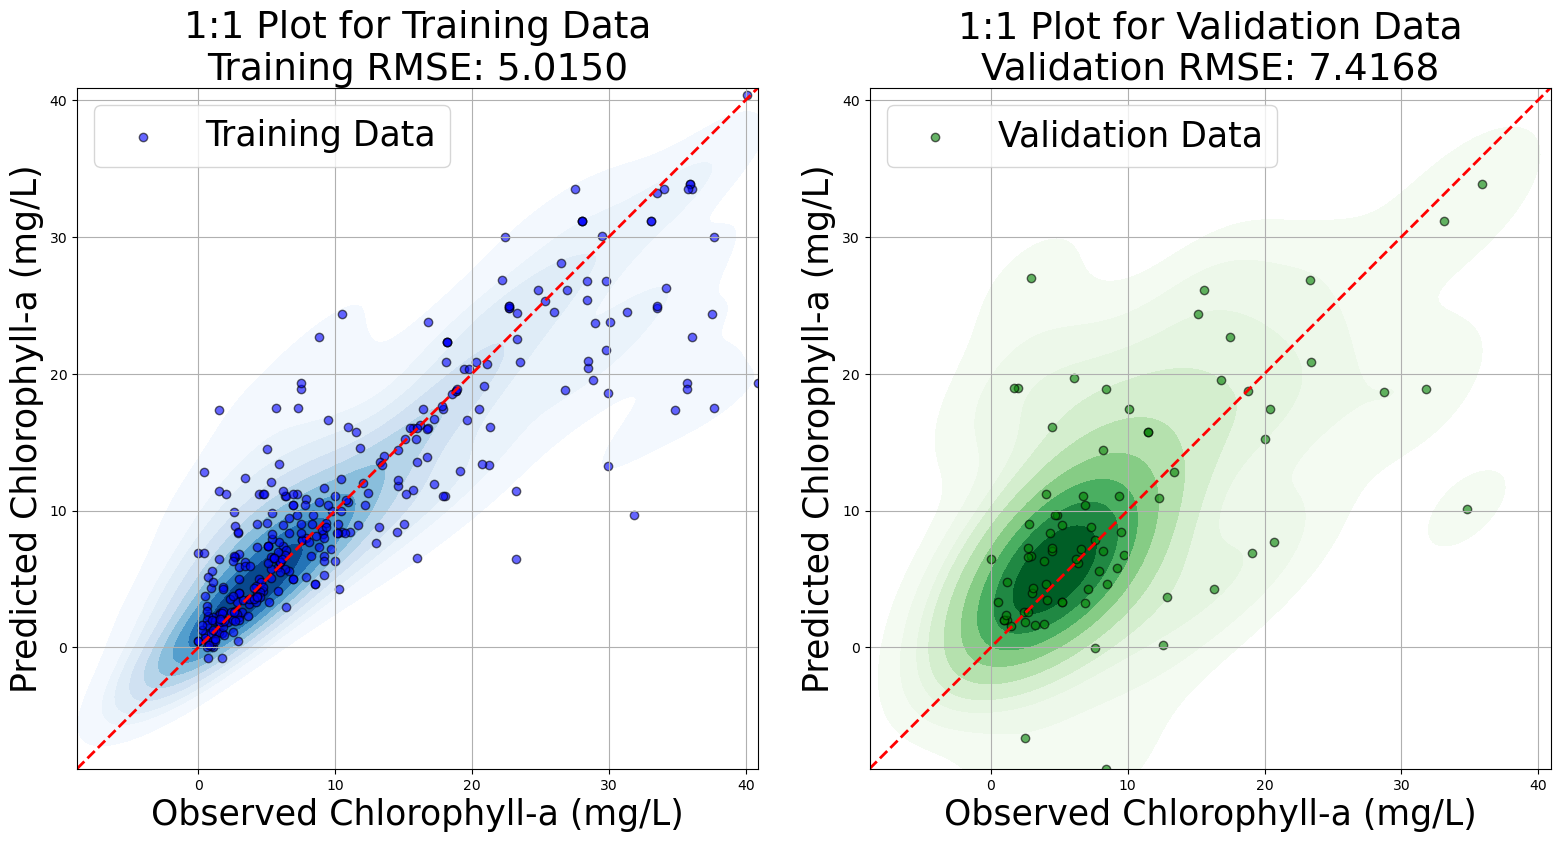

In [696]:
# Evaluate the model
model.eval()
with torch.no_grad():
    # Predictions on the training set
    train_predictions = model(X_train_tensor)
    train_loss = torch.sqrt(torch.mean((train_predictions - y_train_tensor) ** 2))  # Calculate RMSE for training
    print(f"Root Mean Squared Error on training data: {train_loss.item():.4f}")
    
    # Predictions on the test set
    test_predictions = model(X_test_tensor)
    test_loss = torch.sqrt(torch.mean((test_predictions - y_test_tensor) ** 2))  # Calculate RMSE for test
    print(f"Root Mean Squared Error on test data: {test_loss.item():.4f}")

# Convert predictions and true values to numpy arrays for inverse scaling
train_predictions = train_predictions.numpy().flatten()
test_predictions = test_predictions.numpy().flatten()
y_train = y_train_tensor.numpy().flatten()
y_test = y_test_tensor.numpy().flatten()

# Inverse transform the predictions and true values back to the original scale
train_predictions_original = scaler_y.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
test_predictions_original = scaler_y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Determine the global min and max across both training and test sets for consistency
global_min = min(min(y_train_original), min(train_predictions_original), min(y_test_original), min(test_predictions_original))
global_max = max(max(y_train_original), max(train_predictions_original), max(y_test_original), max(test_predictions_original))

# Calculate RMSE for training and validation data
training_rmse = np.sqrt(mean_squared_error(y_train_original, train_predictions_original))
validation_rmse = np.sqrt(mean_squared_error(y_test_original, test_predictions_original))

# Set font size for the plots
font_size = 25

# Create a figure with subplots
plt.figure(figsize=(16, 8))  # Adjusting width for side-by-side plots

# 1:1 Plot for Training Data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.kdeplot(x=y_train_original, y=train_predictions_original, cmap="Blues", fill=True, bw_adjust=1)
plt.scatter(y_train_original, train_predictions_original, color='blue', edgecolor='k', alpha=0.6, label='Training Data')
plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)  # 1:1 line from max to min
plt.xlabel('Observed Chlorophyll-a (mg/L)', fontsize=font_size)
plt.ylabel('Predicted Chlorophyll-a (mg/L)', fontsize=font_size)
plt.title(f'1:1 Plot for Training Data\nTraining RMSE: {training_rmse:.4f}', fontsize=font_size + 2)
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
plt.gca().set_aspect('equal', adjustable='box')  # Ensure aspect ratio is equal
plt.legend(fontsize=font_size)
plt.grid(True)

# 1:1 Plot for Validation/Test Data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.kdeplot(x=y_test_original, y=test_predictions_original, cmap="Greens", fill=True, bw_adjust=1)
plt.scatter(y_test_original, test_predictions_original, color='green', edgecolor='k', alpha=0.6, label='Validation Data')
plt.plot([global_min, global_max], [global_min, global_max], color='red', linestyle='--', linewidth=2)  # 1:1 line from max to min
plt.xlabel('Observed Chlorophyll-a (mg/L)', fontsize=font_size)
plt.ylabel('Predicted Chlorophyll-a (mg/L)', fontsize=font_size)
plt.title(f'1:1 Plot for Validation Data\nValidation RMSE: {validation_rmse:.4f}', fontsize=font_size + 2)
plt.xlim(global_min, global_max)
plt.ylim(global_min, global_max)
plt.gca().set_aspect('equal', adjustable='box')  # Ensure aspect ratio is equal
plt.legend(fontsize=font_size)
plt.grid(True)

# Adjust layout and show the entire figure with both subplots
plt.tight_layout()
plt.show()